### Wafer maps
#### - wafer 품질검사 분류기
 - **data** : http://mirlab.org/dataSet/public/
 
> *811457 웨이퍼 맵, 각 웨이퍼 맵은 실제 제작에서 수집되었습니다.* 
> 
> *WM-811K 데이터 세트에서 웨이퍼 맵의 약 20%에 대한 패턴 유형에 주석을 달기 위해 도메인 전문가를 모집했습니다.*
>
> 기부일자 : **2015년 2월**
>
> 수집한 사람 : **Roger Jang, professor**
>
> 수집한 장소 : **mirlab**

**데이터 사용을 위한 인용 구문 두 문장**

> [1] Ming-Ju Wu, Jyh-Shing Roger Jang, and Jui-Long Chen, "Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets," in IEEE Transactions on Semiconductor Manufacturing, vol. 28, no. 1, pp. 1-12, Feb. 2015, doi: 10.1109/TSM.2014.2364237.

> [2] MIR-WM811K: Dataset for wafer map failure pattern recognition, 2015 http://mirlab.org/dataset/public/

 **shape**의 설명 :
 > waferMap : 2차원 배열에 각기 다른 shape의 숫자들이 기록되어 있다.
 >
          - 0 : wafer가 존재하지 않는 영역
          - 1 : wafer안의 normal die가 존재
          - 2 : defect(결함) die가 존재
 
 - die size :
 
 > wafer안의 하나의 칩의 크기를 말해준다.
 
 - 불량의 타입 :
 ***불량의 종류에는 다음과 같이 존재한다.***
> [사진] 들어갈 예정
 
 - 개발모델 : CNN, Flatten 후 DNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# 리눅스 한글 설정
plt.rc('font', family = 'NanumGothic')

In [3]:
df = pd.read_pickle('LSWMD.pkl')

## 데이터 탐색

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [5]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [6]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [7]:
np.unique(df['waferIndex'], return_counts = True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 array([32516, 32663, 32621, 32714, 32701, 32745, 32672, 32650, 32636,
        32586, 32637, 32598, 32381, 32353, 32301, 32362, 32333, 32333,
        32285, 32290, 32320, 32312, 32202, 32197, 32049]))

In [8]:
np.unique(df['lotName'], return_counts = True)

(array(['lot1', 'lot10', 'lot100', ..., 'lot9997', 'lot9998', 'lot9999'],
       dtype=object),
 array([25, 25, 25, ..., 23, 23, 23]))

### 1. 데이터 정제

In [9]:
print(df['waferMap'][0].shape)

(45, 48)


In [10]:
#print(df['waferMap'].shape)
#dim_x = np.size(df['waferMap'][0], axis = 0)
#print(dim_x)

# columns의 name 바꾸기
df.columns = ['wafermap', 'diesize', 'lotname', 'waferindex', 'traintestlabel', 'failuretype']

# 2차원 shape 가져오기
def check_shape(df_data):
    return df_data.shape

df['waferdims'] = df['wafermap'].apply(check_shape)

In [11]:
# train_test_lable과 failuretype의 이차원 배열 벗기기
def out_array(df_data):
    x = df_data
    if len(x)>0:
        return x[0,0]
    else:
        return np.NaN

In [12]:
# train_test_label과 failuretype의 라벨값 뽑아내기
df['train_test_label'] = df['traintestlabel'].apply(out_array)
df['failure_type'] = df['failuretype'].apply(out_array)

In [13]:
# 필요없는 columns drop
df.drop(['traintestlabel', 'failuretype'], axis = 1, inplace = True)

In [14]:
df.head()

,wafermap,diesize,lotname,waferindex,waferdims,train_test_label,failure_type
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,"(45, 48)",Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,"(45, 48)",Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,"(45, 48)",Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,"(45, 48)",Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,"(45, 48)",Training,none


In [15]:
#np.unique(df['waferdims'], return_counts = True)
df['waferdims'].value_counts().index

Index([(32, 29), (25, 27), (49, 39), (26, 26), (30, 34), (33, 33), (33, 29),
       (39, 37), (52, 59), (31, 31),
       ...
       (26, 44), (54, 64), (37, 51), (54, 65), (49, 67), (53, 70), (99, 69),
       (38, 50), (45, 47), (27, 71)],
      dtype='object', name='waferdims', length=632)

### 2. 모델을 만들기 위해 wafermap의 shape이 일정해야 한다.

In [22]:
# shape의 max값을 찾아야한다.
# shape의 max값은 (300,202)이고, min값은 (6, 21)이다.
# 이러면 가장 작은 값이 잘 안보일 수 있기 때문에 
# 가장 큰 max값 19개로 81만개의 일부이기 때문에 drop하고 두번 째 큰 값을 기준으로 맞추자는 방향
print(df['waferdims'].max())
filter1 = df['waferdims'] == (300, 202)
print('가장 큰 shape은 ', len(df[filter1]), '개 이다.')

(300, 202)
가장 큰 shape은  19 개 이다.


In [17]:
# 두번째 가장 큰 shape을 찾기 위해
# (x, y)중 x가 두번째로 큰것
v = list(df['waferdims'].value_counts().index)
v.sort(key = lambda x:x[0])
print('튜플에서 x는 :', v[-10:]) # x는 212


# (x,y)중 y가 두번째로 큰 것
m = list(df['waferdims'].value_counts().index)
v.sort(key = lambda x:x[1])
print('튜플에서 y는 :', v[-10:])

튜플에서 x는 : [(147, 116), (148, 183), (151, 78), (152, 172), (153, 187), (155, 175), (156, 139), (173, 48), (212, 84), (300, 202)]
튜플에서 y는 : [(63, 160), (152, 172), (155, 175), (107, 183), (148, 183), (153, 187), (300, 202), (122, 204), (144, 204), (136, 205)]


In [18]:
# 하지만 생각보다 max 값과 min값이 차이가 너무나서 분포도를 그려 분포가 적은 기준을 잡아 기준에 적합하지 않은 값들은 drop
# 튜플의 x 값 추출
list2 = []
for i in df['waferdims']:
    list2.append(i[0])
    
# 튜플의 y 값 추출
list3 = []
for e in df['waferdims']:
    list3.append(e[1])

/tmp/ipykernel_3028/369634910.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = list2, ax = axes[1, 0])
/tmp/ipykernel_3028/369634910.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = list3, ax = axes[1, 1])


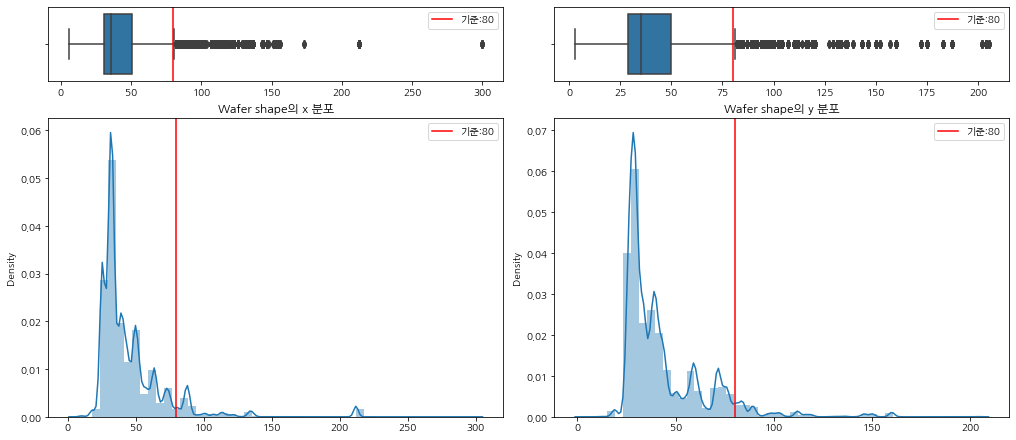

In [23]:
# x와 y의 분포를 보자

fig, axes = plt.subplots(2,2, figsize = (14,6), height_ratios=[.2, .8], layout = 'constrained')

sns.boxplot(x = list2, ax = axes[0, 0])
sns.distplot(x = list2, ax = axes[1, 0])
sns.boxplot(x = list3, ax = axes[0, 1])
sns.distplot(x = list3, ax = axes[1, 1])

axes[1, 0].axvline(x = 80, color = 'r', linewidth = 1.5, label = '기준:80')
axes[1, 1].axvline(x = 80, color = 'r', linewidth = 1.5, label = '기준:80')
axes[0, 0].axvline(x = 80, color = 'r', linewidth = 1.5, label = '기준:80')
axes[0, 1].axvline(x = 80, color = 'r', linewidth = 1.5, label = '기준:80')
#axes[0].axvline(list2.median(), color='r', linewidth=2.5, label='중앙값 : '+ str(list2.median()))
#axes[0].axvline(list2.mean(), color='g', linewidth=2.5, label='평균값 : '+ str(list2.mean()))

axes[1, 0].legend(loc = 'upper right')
axes[1, 0].set_title('Wafer shape의 x 분포')
axes[1, 1].legend(loc = 'upper right')
axes[1, 1].set_title('Wafer shape의 y 분포')
axes[0, 0].legend(loc = 'upper right')
axes[0, 1].legend(loc = 'upper right')

In [24]:
# 대부분의 shape이 100아래에 존재하기 때문에 100을 기준으로 100 이상의 것들은 drop
# 우선 100이상의 것들을 뽑아내기 위해
def check_tuple(s):
    if (s[0] > 80) | (s[1] > 80):
        return False
    else:
        return True

In [25]:
#filter1 = df['wafermap']
df['check_tuple'] = df['waferdims'].apply(check_tuple)

In [26]:
df.head()

,wafermap,diesize,lotname,waferindex,waferdims,train_test_label,failure_type,check_tuple
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,"(45, 48)",Training,none,True
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,"(45, 48)",Training,none,True
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,"(45, 48)",Training,none,True
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,"(45, 48)",Training,none,True
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,"(45, 48)",Training,none,True


In [27]:
# 이상치 제거
# True값만 남기고 False는 다 제거
print(df['check_tuple'].value_counts())

check_tuple
True     745630
False     65827
Name: count, dtype: int64


In [28]:
# 조건 만족 행 drop
filter2 = df['check_tuple'] == False
df.drop(df[filter2].index, axis=0, inplace = True)
df = df.reset_index()

In [29]:
# 이상치 제거 확인
df['check_tuple'].value_counts()

check_tuple
True    745630
Name: count, dtype: int64

In [30]:
#다시 한 번 check
v = list(df['waferdims'].value_counts().index)
v.sort(key = lambda x:x[0])
print('튜플에서 x는 :', v[-10:])

m = list(df['waferdims'].value_counts().index)
m.sort(key = lambda x:x[1])
print('튜플에서 y는 :', m[-10:])

튜플에서 x는 : [(77, 60), (77, 47), (78, 80), (79, 80), (79, 58), (79, 79), (79, 68), (79, 33), (80, 77), (80, 73)]
튜플에서 y는 : [(73, 79), (69, 79), (75, 79), (79, 79), (68, 79), (72, 80), (79, 80), (68, 80), (58, 80), (78, 80)]


### 남은 wafer의 shape을 확인해보자

(63, 62)
(32, 29)


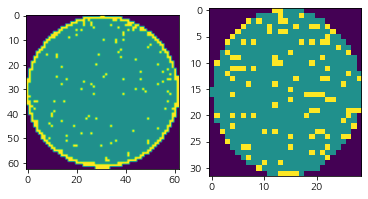

In [31]:
_, axe = plt.subplots(1,2)
axe[0].imshow(df['wafermap'][142524])
print(df['waferdims'][142524])
axe[1].imshow(df['wafermap'][469440])
print(df['waferdims'][469440])

### 4. wafer 크기 맞추기
**1. 모델을 생성하기 위해서는 wafer 데이터가 저장되어있는 shape을 맞춰야한다.**

**2. 웨이퍼가 없는 곳의 데이터 0의 영역을 넓히고, 가운대 부분에 wafer을 끼워 넣는 형식으로 <span style='background-color:#fff5b1'>수동 패딩 (Padding)</span>진행**

***3. 최대크기인 80을 기준으로 (80,80)의 0의 영역을 생성하고 가운대 부분에 붙여 넣기***

In [32]:
# Padding을 위해 [80,80] 2차원 ndarray생성
nda_test = np.zeros([80,80]).astype(np.uint8)

# Padding을 위해 두개의 type확인
print('******type확인******')
print(type(nda_test))
print(type(df['wafermap'][0]))
print('')
print('******dtype확인******')
print(df['wafermap'][0].dtype)
print(nda_test.dtype)
print('')
print('******shape확인******')
print(df['wafermap'][0].shape)
print(nda_test.shape)

******type확인******
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

******dtype확인******
uint8
uint8

******shape확인******
(45, 48)
(80, 80)


### 두개의 영역 시각적 확인

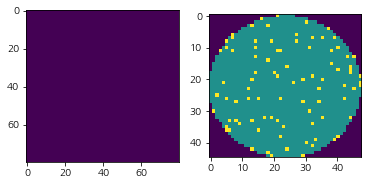

In [33]:
_, axe = plt.subplots(1,2)
axe[0].imshow(nda_test)
axe[1].imshow(df['wafermap'][0])

#### 방법 설명
- 70이상이면 0,0부터 시작하고 60이상이면 5,5부터... 시작 이런식으로 5의 배수배로 edge Padding을 준다."

> - ***shape이 (x_tar, y_tar)이고 x_tar, y_tar 둘 다 70이상의 수라고 가정하면,***
>
>>1. x_index는 0 + (80-x_tar)//2, y_index는 0 + (80-y_tar)//2에서 시작한다.
>>
>>2. 끝나는 점도 정확히 넣어줘야 broadcasting이 되기 때문에 (x_tar + x_index, y_tar + y_index)로 해준다.
>>
>>3. 즉 broadcasting 범위는 ***[x_index:(x_tar+x_index), y_index+(y_tar+y_index)]*** 된다.

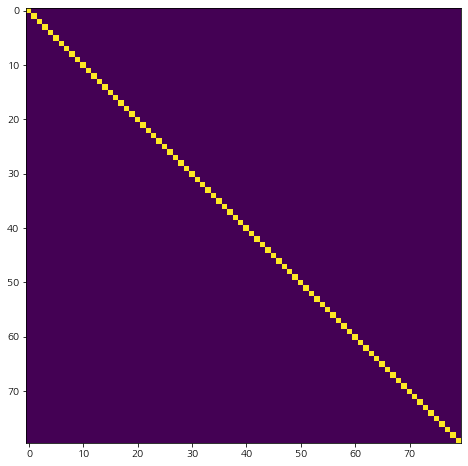

In [37]:
nda_test1 = np.zeros([80,80]).astype(np.uint8)
for i in range(80):
    nda_test1[i,i] = 1

fig, axe = plt.subplots(figsize = (8,8))
axe.imshow(nda_test1)

In [38]:
# example df['wafermap'][0]인 (45,48) 넣기
# 70이상 (0,0) 60이상 (5,5) 50이상 (10,10), 40이상 (15,15) 
x_index = 15 + (50 - 45)//2
y_index = 15 + (50 - 48)//2
print(x_index, y_index)
nda_test[x_index:(45+x_index), y_index:(48+y_index)] = df['wafermap'][0]

17 16


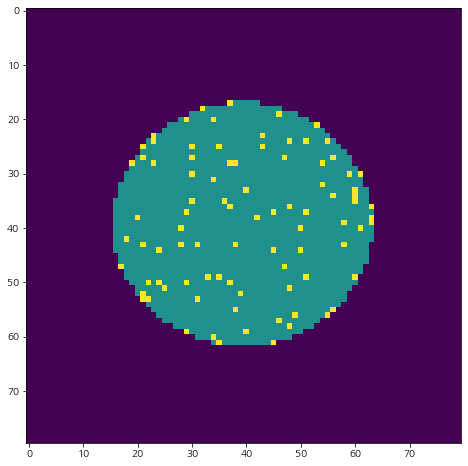

In [39]:
fig, axe = plt.subplots(figsize = (8,8))
axe.imshow(nda_test)

In [40]:
def reshape(df_wafer, x_tar, y_tar):
    nda_2 = np.zeros([80,80])
    if (x_tar >= 70) | (y_tar >= 70):
        x_index = 0 + (80 - x_tar) // 2
        y_index = 0 + (80 - y_tar) // 2 
        nda_2[x_index:(x_tar+x_index), y_index:(y_tar+y_index)] = df_wafer
        return nda_2
    elif (x_tar >= 60) | (y_tar >= 60):
        x_index = 5 + (70 - x_tar) // 2
        y_index = 5 + (70 - y_tar) // 2 
        nda_2[x_index:(x_tar+x_index), y_index:(y_tar+y_index)] = df_wafer
        return nda_2
    elif (x_tar >= 50) | (y_tar >= 50):
        x_index = 10 + (60 - x_tar) // 2
        y_index = 10 + (60 - y_tar) // 2 
        nda_2[x_index:(x_tar+x_index), y_index:(y_tar+y_index)] = df_wafer
        return nda_2
    elif (x_tar >= 40) | (y_tar >= 40):
        x_index = 15 + (50 - x_tar) // 2
        y_index = 15 + (50 - y_tar) // 2 
        nda_2[x_index:(x_tar+x_index), y_index:(y_tar+y_index)] = df_wafer
        return nda_2
    elif (x_tar >= 30) | (y_tar >= 30):
        x_index = 20 + (40 - x_tar) // 2
        y_index = 20 + (40 - y_tar) // 2 
        nda_2[x_index:(x_tar+x_index), y_index:(y_tar+y_index)] = df_wafer
        return nda_2
    elif (x_tar >= 20) | (y_tar >= 20):
        x_index = 25 + (30 - x_tar) // 2
        y_index = 25 + (30 - y_tar) // 2 
        nda_2[x_index:(x_tar+x_index), y_index:(y_tar+y_index)] = df_wafer
        return nda_2
    elif (x_tar >= 10) | (y_tar >= 10):
        x_index = 30 + (20 - x_tar) // 2
        y_index = 30 + (20 - y_tar) // 2 
        nda_2[x_index:(x_tar+x_index), y_index:(y_tar+y_index)] = df_wafer
        return nda_2
    else:
        x_index = 35 + (10 - x_tar) // 2
        y_index = 35 + (10 - y_tar) // 2 
        nda_2[x_index:(x_tar+x_index), y_index:(y_tar+y_index)] = df_wafer
        return nda_2

In [ ]:
em_list = []
for i, wafer in enumerate(df['wafermap']):
    time.sleep(0.01)
    em_list.append(reshape(wafer, df['waferdims'][i][0], df['waferdims'][i][1]))
    print(i, em_list)

In [ ]:
# lotname groupby meanmax
# 0부분 패딩 처리
# EDA lot개수 lot별로 fault 난 횟수 여러가지 통계치를 많이 뽑아보자